# species occurances

Let's see if we can build a cohesive model using just the training dataset.

In [2]:
prefix = "gs://dsgt-clef-geolifeclef-2024"
# ! gcloud storage ls {prefix}/data/raw
! gcloud storage du --readable-sizes {prefix}/data/raw/Presence_Absence_surveys/
! gcloud storage du --readable-sizes {prefix}/data/raw/Presence_only_occurrences/

10.72MiB     gs://dsgt-clef-geolifeclef-2024/data/raw/Presence_Absence_surveys/Presences_Absences_train.csv
2.85kiB      gs://dsgt-clef-geolifeclef-2024/data/raw/Presence_Absence_surveys/Readme.txt
2.08MiB      gs://dsgt-clef-geolifeclef-2024/data/raw/Presence_Absence_surveys/enviroTab_pa_train.csv
1.05MiB      gs://dsgt-clef-geolifeclef-2024/data/raw/Presence_Absence_surveys/train_pa_spAround_1km.csv
385.15kiB    gs://dsgt-clef-geolifeclef-2024/data/raw/Presence_Absence_surveys/train_pred_maxent_on_PA.csv
14.23MiB     gs://dsgt-clef-geolifeclef-2024/data/raw/Presence_Absence_surveys/
617.02MiB    gs://dsgt-clef-geolifeclef-2024/data/raw/Presence_only_occurrences/Presences_only_train.csv
1.49kiB      gs://dsgt-clef-geolifeclef-2024/data/raw/Presence_only_occurrences/Readme.txt
617.03MiB    gs://dsgt-clef-geolifeclef-2024/data/raw/Presence_only_occurrences/


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from geolifeclef.utils import get_spark
from pyspark.sql import functions as F

prefix = "gs://dsgt-clef-geolifeclef-2024"

spark = get_spark()
df = spark.read.csv(
    f"{prefix}/data/raw/Presence_only_occurrences/Presences_only_train.csv",
    header=True,
    sep=";",
    inferSchema=True,
).repartition(200)

df = df.cache()
df.printSchema()
df.show(n=1, vertical=True, truncate=80)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/25 23:22:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/02/25 23:22:31 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/02/25 23:22:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/02/25 23:22:31 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


root
 |-- glcID: integer (nullable = true)
 |-- gbifID: double (nullable = true)
 |-- observer: string (nullable = true)
 |-- datasetName: string (nullable = true)
 |-- date: date (nullable = true)
 |-- dayOfYear: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- lon: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- x_EPSG3035: double (nullable = true)
 |-- y_EPSG3035: double (nullable = true)
 |-- geoUncertaintyInM: double (nullable = true)
 |-- speciesId: integer (nullable = true)
 |-- patchID: integer (nullable = true)
 |-- timeSerieID: integer (nullable = true)



-RECORD 0-------------------------------
 glcID             | 3908519            
 gbifID            | 3.954102866E9      
 observer          | NULL               
 datasetName       | Pl@ntNet automatic 
 date              | 2021-08-03         
 dayOfYear         | 215                
 year              | 2021               
 lon               | -4.190946          
 lat               | 47.80078           
 x_EPSG3035        | 3264778.0          
 y_EPSG3035        | 2844868.0          
 geoUncertaintyInM | 25.0               
 speciesId         | 7577               
 patchID           | 3183249            
 timeSerieID       | 165479             
only showing top 1 row



In [5]:
df.count()

4908319

In [6]:
df.where("dayOfYear is null").count(), df.select(F.countDistinct("speciesId")).show()

+-------------------------+
|count(DISTINCT speciesId)|
+-------------------------+
|                    10038|
+-------------------------+



(0, None)

In [10]:
from math import pi

geotime_df = df.select(
    "lat",
    "lon",
    F.col("dayOfYear").alias("doy"),
    F.sin(2 * pi * F.col("dayOfYear") / 365.25).alias("sin_doy"),
    F.cos(2 * pi * F.col("dayOfYear") / 365.25).alias("cos_doy"),
    "speciesId",
)
geotime_df.show(n=5)

+--------+---------+---+--------------------+--------------------+---------+
|     lat|      lon|doy|             sin_doy|             cos_doy|speciesId|
+--------+---------+---+--------------------+--------------------+---------+
|47.80078|-4.190946|215| -0.5285813283559292| -0.8488826652214553|     7577|
|42.61421|-7.098505|167| 0.26556302780405594| -0.9640935007889755|     5072|
|43.28681|-2.155409|132|  0.7648913904341226| -0.6441592666722685|     6895|
|43.38847| -2.99161|253| -0.9358348973349941|-0.35243871088460327|     9965|
|48.57949| 2.444746|184|-0.02365112724523...| -0.9997202729664083|     4974|
+--------+---------+---+--------------------+--------------------+---------+
only showing top 5 rows



In [11]:
# let's only keep the top k species for analysis
top_k = 10
top_species = (
    df.groupBy("speciesId")
    .count()
    .orderBy(F.desc("count"))
    .limit(top_k)
    .select("speciesId")
)
df_subset = geotime_df.join(top_species, "speciesId", "inner").cache()
df_subset.count()

45461

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np

pdf = geotime_df.toPandas()

X = pdf[["lat", "lon", "sin_doy", "cos_doy"]]
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


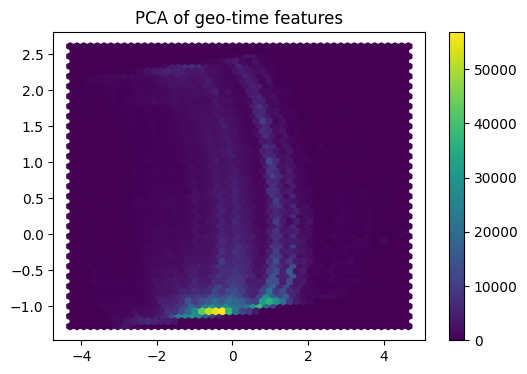

In [24]:
plt.figure(figsize=(6, 4))
# plt.scatter(X_pca[:500, 0], X_pca[:500, 1])
# show a heatmap of the density of the points
plt.hexbin(X_pca[:, 0], X_pca[:, 1], gridsize=50, cmap="viridis")
plt.colorbar()
plt.title("PCA of geo-time features")
plt.show()

In [26]:
# let's do it again for the subset
pdf = df_subset.toPandas()
X = pdf[["lat", "lon", "sin_doy", "cos_doy"]]
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


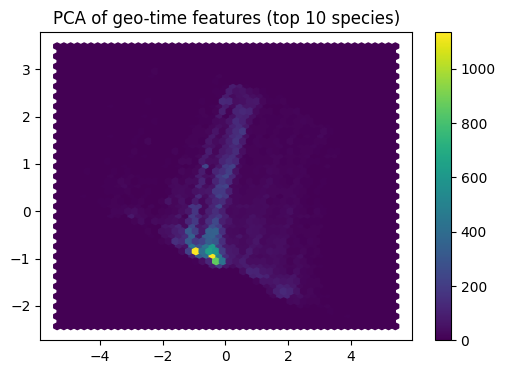

In [27]:
plt.figure(figsize=(6, 4))
# plt.scatter(X_pca[:500, 0], X_pca[:500, 1])
# show a heatmap of the density of the points
plt.hexbin(X_pca[:, 0], X_pca[:, 1], gridsize=50, cmap="viridis")
plt.colorbar()
plt.title("PCA of geo-time features (top 10 species)")
plt.show()

In [28]:
# clean up
del pdf, X, X_pca, scaler, pca

How well does this data predict species?
Let's try this out using a very simple linear model first, and then try more complex variations.
We'll start off with using spark-ml, because the naive approach of using pandas and scikit-learn is certainly not going to work with this dataset.

In [30]:
# how good is this data for predicting species?
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

assembler = VectorAssembler(
    inputCols=["lat", "lon", "sin_doy", "cos_doy"],
    outputCol="features",
)
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features",
    withStd=True,
    withMean=True,
)
lr = LogisticRegression(
    labelCol="speciesId",
    featuresCol="features",
    maxIter=10,
    regParam=0.3,
    elasticNetParam=0.8,
)
pipeline = Pipeline(stages=[assembler, scaler, lr])

# fit the model
# do a stratified split to ensure that we have enough examples of each species in the test set
train, test = df_subset.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train)

# evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="speciesId", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(model.transform(test))
print(f"Accuracy = {accuracy}")

Accuracy = 0.09687977307440541
